# Step 1.Reading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = '/content/drive/My Drive/eDO_data_M1.csv'

In [ ]:
import pandas as pd
import numpy as np

def calculate_rsi(series, window=14):
    """
    Calculate the Relative Strength Index (RSI) for a given series.

    Parameters:
    series (pd.Series): The price series for which to calculate RSI.
    window (int): The period for calculating RSI (default is 14).

    Returns:
    pd.Series: RSI values.
    """
    delta = series.diff()  # Price changes
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()  # Average gain
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()  # Average loss
    rs = gain / loss  # Relative strength
    rsi = 100 - (100 / (1 + rs))  # RSI formula
    return rsi

def process_data_with_momentum_target(data_path):
    """
    Process the data to resample to a 1-hour timeframe, calculate RSI, and define a Momentum Target.

    Parameters:
    data_path (str): Path to the CSV file containing the data.

    Returns:
    pd.DataFrame: Processed data with features and momentum target column.
    """
    # Step 1: Read the data
    data = pd.read_csv(data_path, header=None, names=['TimeStamp', 'open', 'high', 'low', 'close', 'volume'])
    data['TimeStamp'] = pd.to_datetime(data['TimeStamp'])
    data.set_index('TimeStamp', inplace=True)

    # Step 2: Resample the data to a 1-hour timeframe
    resampled_data = data.resample('1H').agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    }).dropna()

    # Step 3: Calculate RSI
    resampled_data['RSI'] = calculate_rsi(resampled_data['close'], window=14)

    # Step 4: Define Momentum Target
    def categorize_rsi(rsi):
        if rsi < 30:
            return 'A'  # Oversold
        elif 30 <= rsi < 50:
            return 'B'  # Weak momentum
        elif 50 <= rsi < 70:
            return 'C'  # Moderate momentum
        elif rsi >= 70:
            return 'D'  # Overbought
        else:
            return 'Unknown'

    resampled_data['Momentum_Target'] = resampled_data['RSI'].apply(categorize_rsi)

    # Drop rows with NaN values (due to RSI calculation)
    resampled_data.dropna(inplace=True)

    return resampled_data

# Example usage:
#data_path = '/mnt/data/eDO_data_M1.csv'  # Replace with your file path
resampled_data = process_data_with_momentum_target(data_path)
#print(processed_data[['RSI', 'Momentum_Target']].head())


<ipython-input-3-1ad2317fedbd>:38: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_data = data.resample('1H').agg({


In [ ]:
resampled_data.head()

,open,high,low,close,volume,RSI,Momentum_Target
TimeStamp,,,,,,,
2022-01-01 13:00:00,47074.05,47199.67,46935.09,47023.24,454.14412,59.136954,C
2022-01-01 14:00:00,47023.24,47100.00,46850.18,46926.22,503.66220,56.412545,C
2022-01-01 15:00:00,46920.01,47491.14,46871.69,47219.04,1515.95305,59.682619,C
2022-01-01 16:00:00,47219.04,47527.24,47186.07,47268.62,1049.57919,59.963100,C
2022-01-01 17:00:00,47268.61,47954.63,47238.81,47754.48,1320.66577,66.946931,C


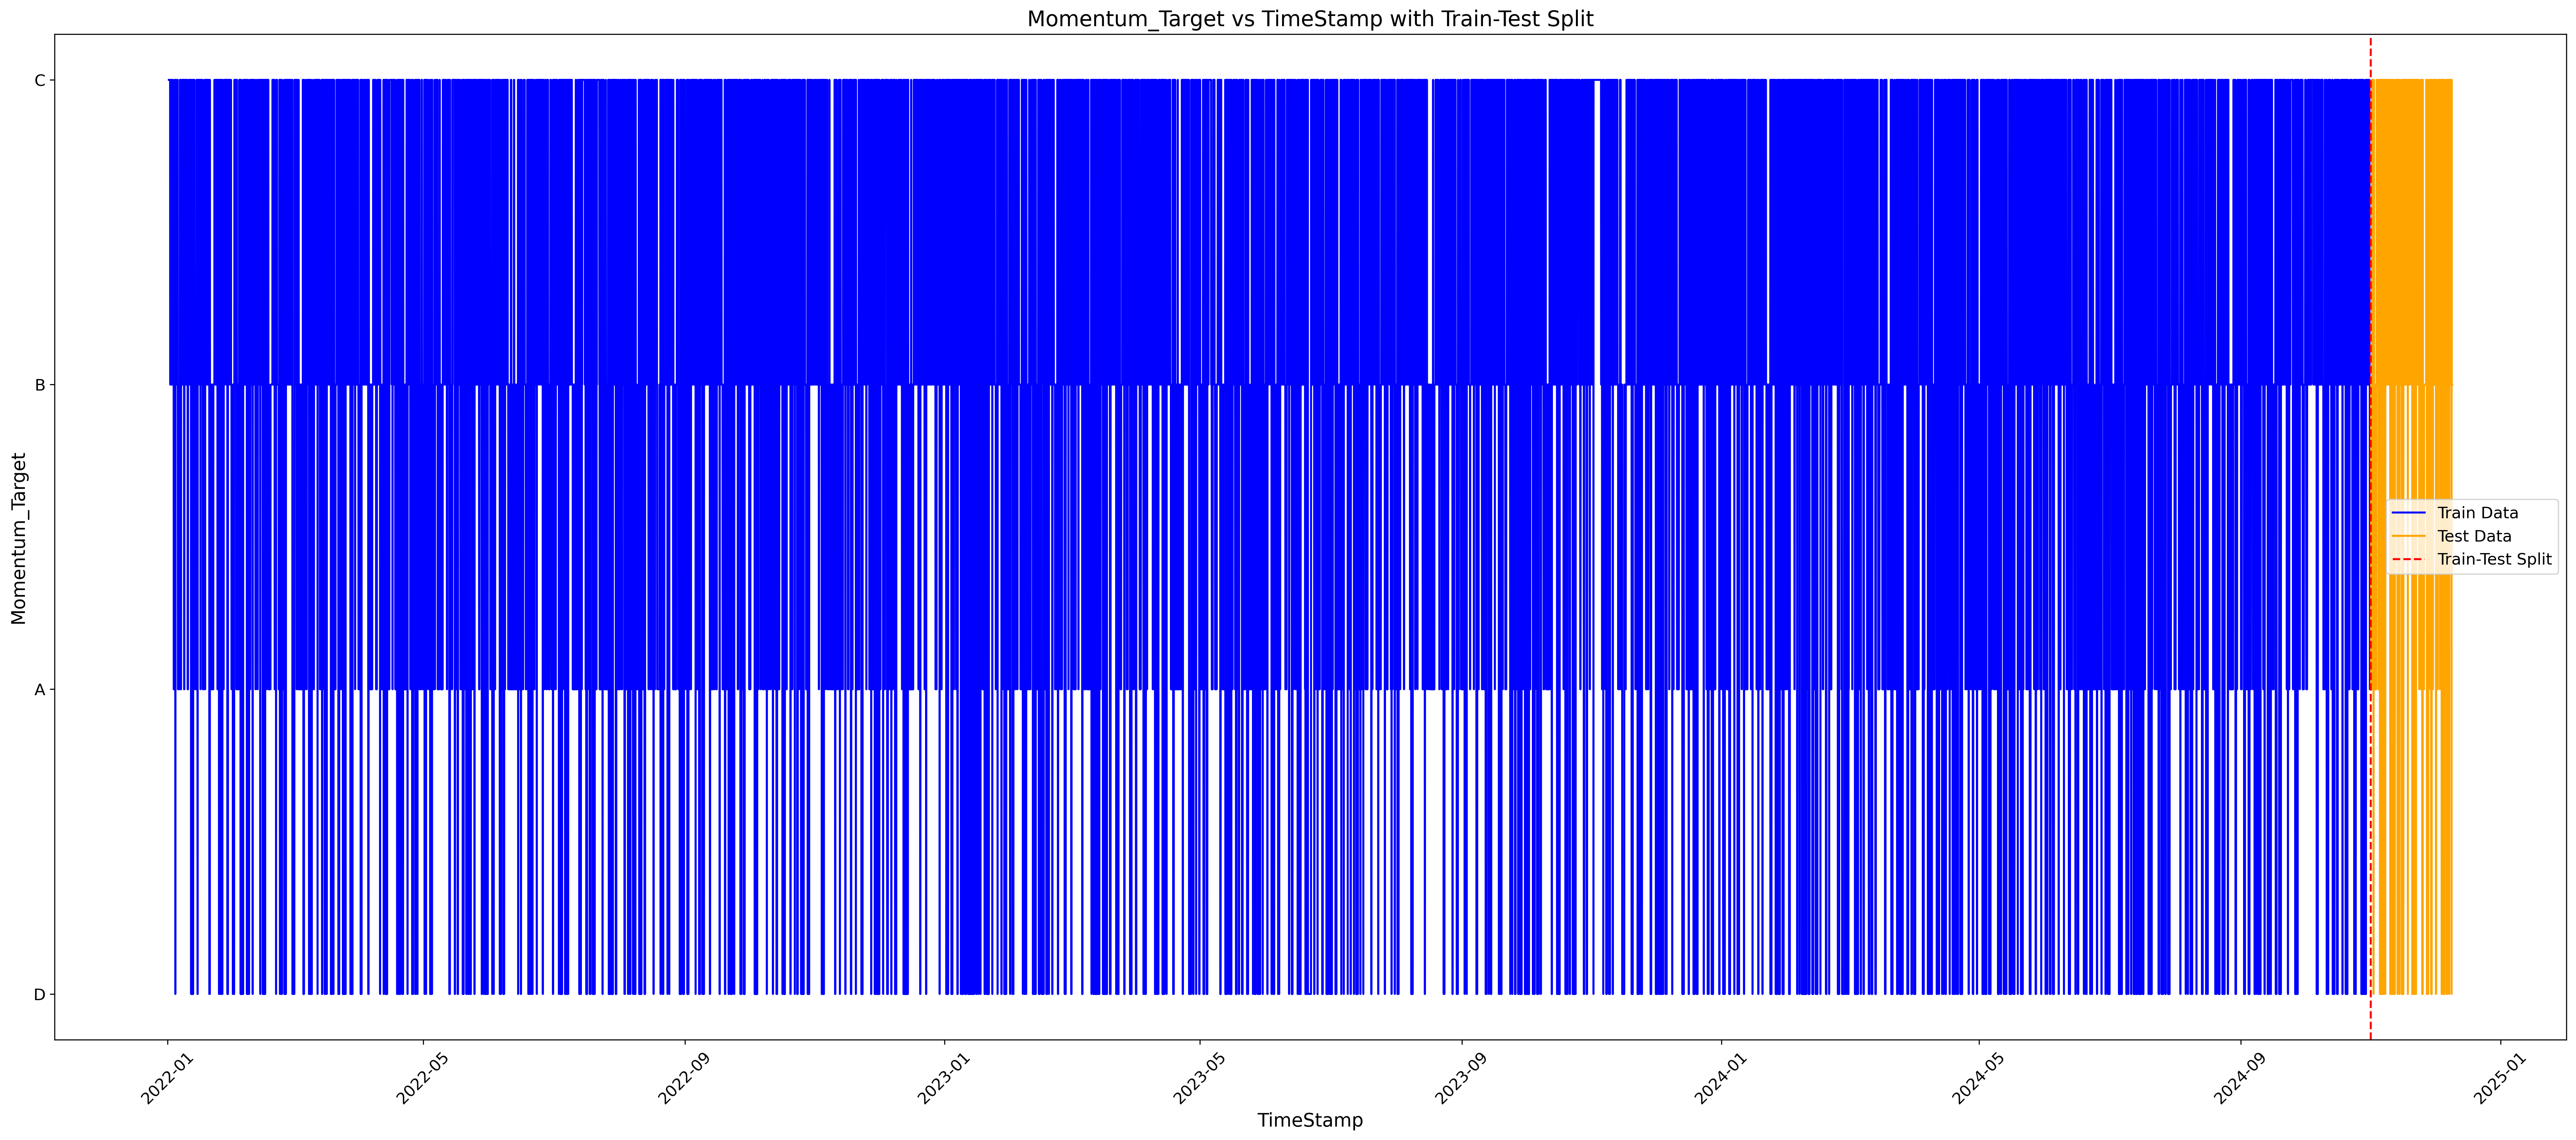

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure TimeStamp is a column
if 'TimeStamp' not in resampled_data.columns:
    resampled_data = resampled_data.reset_index()

# Ensure TimeStamp is in datetime format
resampled_data['TimeStamp'] = pd.to_datetime(resampled_data['TimeStamp'])

# Split the data into train and test sets
train_data = resampled_data[resampled_data['TimeStamp'] < '2024-11-01']
test_data = resampled_data[resampled_data['TimeStamp'] >= '2024-11-01']

# Plot train and test data on the same graph
plt.figure(figsize=(27, 12), dpi=300)  # High-resolution figure

# Plot train data
sns.lineplot(x='TimeStamp', y='Momentum_Target', data=train_data, label='Train Data', color='blue')

# Plot test data
sns.lineplot(x='TimeStamp', y='Momentum_Target', data=test_data, label='Test Data', color='orange')

# Highlight the split point
plt.axvline(x=pd.to_datetime('2024-11-01'), color='red', linestyle='--', linewidth=1.5, label='Train-Test Split')

# Add labels, legend, and title
plt.title('Momentum_Target vs TimeStamp with Train-Test Split', fontsize=16)
plt.xlabel('TimeStamp', fontsize=14)
plt.ylabel('Momentum_Target', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()

# Save and show the plot
plt.savefig('train_test_split_plot.png', dpi=300)
plt.show()


In [ ]:
import plotly.graph_objects as go
import pandas as pd

# Assuming `resampled_data` is already prepared with a datetime index
# Split the data into train and test sets
train_data = resampled_data[resampled_data['TimeStamp'] < '2024-11-01']
test_data = resampled_data[resampled_data['TimeStamp'] >= '2024-11-01']

# Create the dynamic graph
fig = go.Figure()

# Add train data
fig.add_trace(go.Scatter(
    x=train_data['TimeStamp'],
    y=train_data['Momentum_Target'],
    mode='lines',
    name='Train Data',
    line=dict(color='blue')
))

# Add test data
fig.add_trace(go.Scatter(
    x=test_data['TimeStamp'],
    y=test_data['Momentum_Target'],
    mode='lines',
    name='Test Data',
    line=dict(color='orange')
))

# Add a vertical line for the split
fig.add_shape(
    type='line',
    x0='2024-11-01', x1='2024-11-01',
    y0=min(resampled_data['Momentum_Target']), y1=max(resampled_data['Momentum_Target']),
    line=dict(color='red', dash='dash'),
    name='Train-Test Split'
)

# Update layout
fig.update_layout(
    title='Momentum_Target vs TimeStamp with Train-Test Split',
    xaxis_title='TimeStamp',
    yaxis_title='Momentum_Target',
    legend_title='Data Split',
    template='plotly_white',
    width=1200,
    height=600
)

# Show the plot
fig.show()


## Random Forest:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Your existing data split:
train_data = resampled_data[resampled_data.index < '2024-11-01']
test_data = resampled_data[resampled_data.index >= '2024-11-01']

# Prepare input features (X) and target (y) for training data
X_train = train_data.drop(['Momentum_Target'], axis=1)
y_train = train_data['Momentum_Target']

# Prepare input features (X) and target (y) for test data
X_test = test_data.drop(['Momentum_Target'], axis=1)
y_test = test_data['Momentum_Target']

# Train the model using training data
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Predictions on the test data
y_pred = model.predict(X_test)

# Evaluate performance on the test data
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 53   0   0   0]
 [  0 347   0   0]
 [  0   0 371   0]
 [  0   0   0 149]]
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        53
           B       1.00      1.00      1.00       347
           C       1.00      1.00      1.00       371
           D       1.00      1.00      1.00       149

    accuracy                           1.00       920
   macro avg       1.00      1.00      1.00       920
weighted avg       1.00      1.00      1.00       920



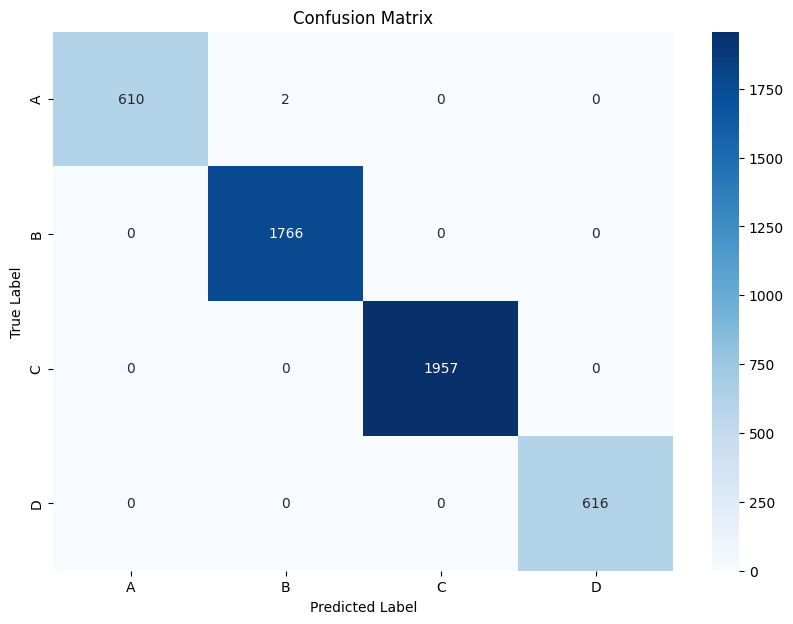

              precision    recall  f1-score   support

           A       1.00      1.00      1.00       612
           B       1.00      1.00      1.00      1766
           C       1.00      1.00      1.00      1957
           D       1.00      1.00      1.00       616

    accuracy                           1.00      4951
   macro avg       1.00      1.00      1.00      4951
weighted avg       1.00      1.00      1.00      4951



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Prepare input features (X) and target (y)
X = train_data.drop(['Momentum_Target'], axis=1)
y = train_data['Momentum_Target']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Validation predictions
y_pred = model.predict(X_val)

# Generate confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print(classification_report(y_val, y_pred))

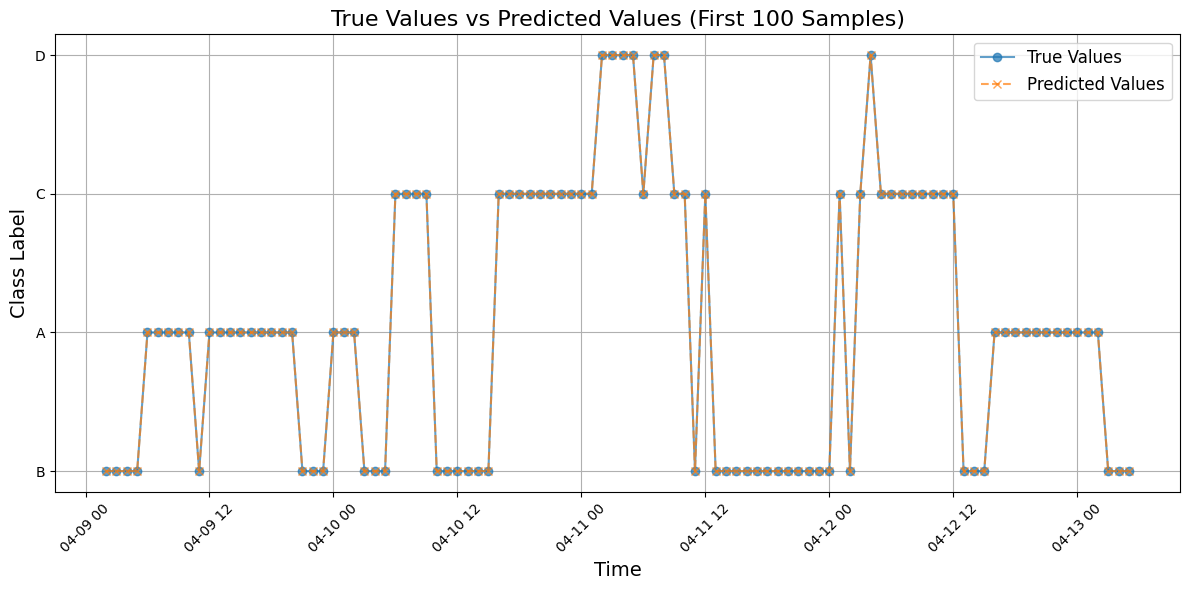

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# ... (your existing code for training the RandomForestClassifier) ...

# Prepare data for plotting (replace 'time_steps' with an appropriate value)
time_steps = 10  # Example, adjust as needed
time_indices = X_val.index[time_steps:]
true_values = y_val[time_steps:]
predicted_values = model.predict(X_val)[time_steps:]

# Plot True vs Predicted Values with Time on X-axis
plt.figure(figsize=(12, 6))
plt.plot(time_indices[:100], true_values[:100], label='True Values', marker='o', linestyle='-', alpha=0.7)
plt.plot(time_indices[:100], predicted_values[:100], label='Predicted Values', marker='x', linestyle='--', alpha=0.7)
plt.title('True Values vs Predicted Values (First 100 Samples)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Class Label', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()